# Neural Networks

## Basic Idea
- Combine input information in a complex & flexible neural net `model`
- Model `coefficients` are continually tweaked in an iterative process
- The network’s interim performance in classification and prediction informs successive tweaks

## Network Structure
- Multiple layers
    - Input layer (raw observations)
    - Hidden layers 
    - Output layer 
- Nodes
- Weights (like coefficients, subject to iterative adjustment)
- Bias values (also like coefficients, but not subject to iterative adjustment) 

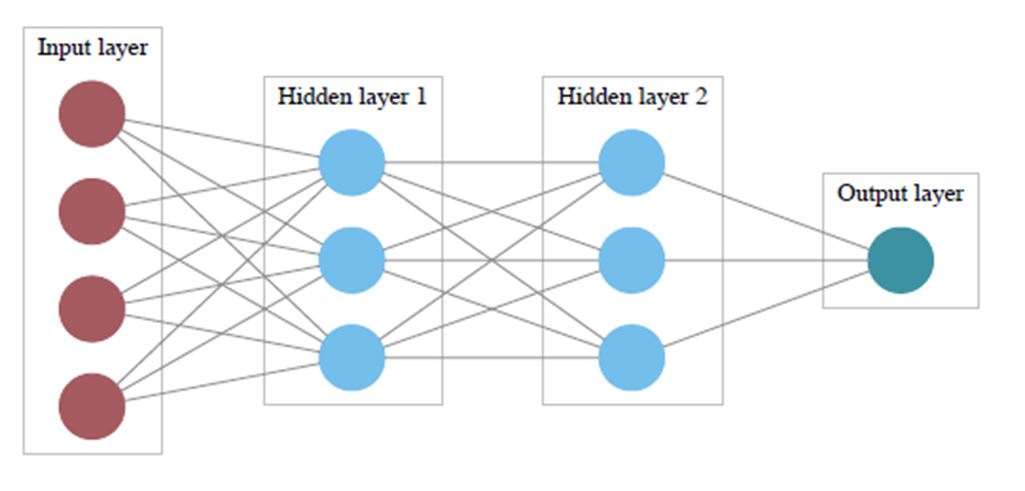

In [1]:
%matplotlib inline

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

from dmba import classificationSummary

import pydotplus
from IPython.display import Image
import numbers

## Tiny Example (Tasting score for a certain processed cheese)

Predict consumer opinion of cheese product based on fat and salt content

The two predictors are scores for fat and salt indicating the relative presence of fat and salt in the particular cheese sample (where 0 is the minimum amount possible in the manufacturing process, and 1 the maximum).

The outcome variable is the cheese sample's consumer taste preference, while like and dislike indicates whether the consimer likes the cheese or not.


In [2]:
example_df = pd.read_csv('data/TinyData.csv')

print(example_df.head(10))

   Obs.  Fat  Salt Acceptance
0     1  0.2   0.9       like
1     2  0.1   0.1    dislike
2     3  0.2   0.4    dislike
3     4  0.2   0.5    dislike
4     5  0.4   0.5       like
5     6  0.3   0.8       like


In [3]:
example_df = pd.read_csv('data/TinyData.csv')

predictors = ['Fat', 'Salt']
outcome = 'Acceptance'

X = example_df[predictors]
y = example_df[outcome]
classes = sorted(y.unique())

clf = MLPClassifier(hidden_layer_sizes=(3), activation='logistic', solver='lbfgs', random_state=1)
clf.fit(X, y)
clf.predict(X)

# Network structure
print('Intercepts')
print(clf.intercepts_)

print('Weights')
print(clf.coefs_)

# Prediction
print(pd.concat([example_df,    
                 pd.DataFrame(clf.predict_proba(X), columns=classes)
                ], axis=1))

Intercepts
[array([0.13368045, 4.07247552, 7.00768104]), array([14.30748676])]
Weights
[array([[ -1.30656481,  -4.20427792, -13.29587332],
       [ -0.04399727,  -4.91606924,  -6.03356987]]), array([[ -0.27348313],
       [ -9.01211573],
       [-17.63504694]])]
   Obs.  Fat  Salt Acceptance   dislike      like
0     1  0.2   0.9       like  0.000490  0.999510
1     2  0.1   0.1    dislike  0.999994  0.000006
2     3  0.2   0.4    dislike  0.999741  0.000259
3     4  0.2   0.5    dislike  0.997368  0.002632
4     5  0.4   0.5       like  0.002133  0.997867
5     6  0.3   0.8       like  0.000075  0.999925


In [4]:
# Pretty print layers
for i, (weights, intercepts) in enumerate(zip(clf.coefs_, clf.intercepts_)):
    print('Hidden layer' if i == 0 else 'Output layer', '{0[0]} => {0[1]}'.format(weights.shape))
    print(' Intercepts:\n ', intercepts)
    print(' Weights:')
    for weight in weights:
        print(' ', weight)
    print()
    
classificationSummary(y, clf.predict(X), class_names=classes)

Hidden layer 2 => 3
 Intercepts:
  [0.13368045 4.07247552 7.00768104]
 Weights:
  [ -1.30656481  -4.20427792 -13.29587332]
  [-0.04399727 -4.91606924 -6.03356987]

Output layer 3 => 1
 Intercepts:
  [14.30748676]
 Weights:
  [-0.27348313]
  [-9.01211573]
  [-17.63504694]

Confusion Matrix (Accuracy 1.0000)

        Prediction
 Actual dislike    like
dislike       3       0
   like       0       3


In [5]:
def layoutGraph(dot_data, pdfFile=None):
    graph = pydotplus.graph_from_dot_data(dot_data)
    return Image(graph.create_png())

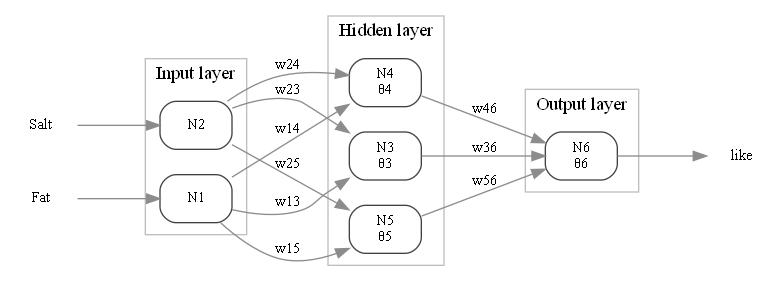

In [6]:

def unbiasedNode(id, label=None, output=None, style=None):
    label = label or f'N{id}'
    common = style or 'shape=record, style=rounded, color=gray26'
    if output is None:
        return f'{id} [ label="{label}", fontsize=11, {common} ];'
    return f'{id} [ label="{{ {label} | {output:.2f} }}", fontsize=11, {common} ];'

def biasedNode(id, bias, label=None, output=None):
    label = label or f'N{id}'
    if isinstance(bias, numbers.Number):
        bias = f'{bias:.3f}'
    if isinstance(output, numbers.Number):
        output = f'{output:.3f}'
    common = 'shape=record, style=rounded, fontsize=11, color=gray26'
    if output is None:
        return f'{id} [ label="{label}&#92;n{bias}", {common} ];'
    return f'{id} [ label="{{ {label}&#92;n{bias} | {output} }}", {common} ];'

def edge(n1, n2, weight=None):
    if weight is None:
        return f'{n1} -> {n2} [ label="w{n1}{n2}" ];'
    return f'{n1} -> {n2} [ label="{weight:.3f}" ];'

commonSettings = """
edge [ fontsize=11, color=gray55 ];
rankdir=LR;
# size="10,10"
graph [ranksep="0.8"];
"""
# node [shape=record, style=rounded, fontsize=11, color=gray26]; 

s = f"""
digraph ethane {{
{ commonSettings }
{ unbiasedNode('Salt', label='Salt', style='color=white') }
{ unbiasedNode('Fat', label='Fat', style='color=white') }
subgraph cluster_input {{ label="Input layer"; color="grey75"; 
    { unbiasedNode(2) }
    { unbiasedNode(1) }
}}
subgraph cluster_hidden {{ label="Hidden layer"; color="grey75"; 
    { biasedNode(4, '&theta;4')}
    { biasedNode(3, '&theta;3')}
    { biasedNode(5, '&theta;5')}
}}
subgraph cluster_output {{ label="Output layer"; color="grey75"; 
    { biasedNode(6, '&theta;6')}
}}
{ unbiasedNode('like', label='like', style='color=white') }
Salt -> 2;
Fat -> 1;
{ edge(1, 3) }
{ edge(2, 3) }
{ edge(1, 4) }
{ edge(2, 4) }
{ edge(1, 5) }
{ edge(2, 5) }
{ edge(3, 6) }
{ edge(4, 6) }
{ edge(5, 6) }
6 -> like
 }}
 """
layoutGraph(s, pdfFile='network-layout.pdf')

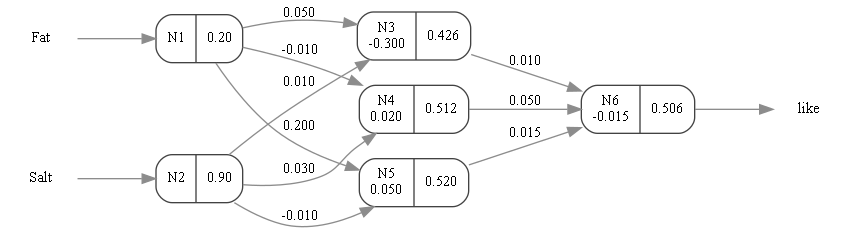

In [7]:
# Random network
s = f"""
digraph ethane {{
{ commonSettings }
{ unbiasedNode('Salt', label='Salt', style='color=white') }
{ unbiasedNode('Fat', label='Fat', style='color=white') }
{ unbiasedNode(2, output=0.9) }
{ unbiasedNode(1, output=0.2) }
{ biasedNode(4, 0.02, output=0.51224755)}
{ biasedNode(3, -0.3, output=0.42580196)}
{ biasedNode(5, 0.05, output=0.520238936)}
{ biasedNode(6, -0.015, output=0.505668252)}
{ unbiasedNode('like', label='like', style='color=white') }
Salt -> 2;
Fat -> 1;
{ edge(1, 3, 0.05) }
{ edge(2, 3, 0.01) }
{ edge(1, 4, -0.01) }
{ edge(2, 4, 0.03) }
{ edge(1, 5, 0.2) }
{ edge(2, 5, -0.01) }
{ edge(3, 6, 0.01) }
{ edge(4, 6, 0.05) }
{ edge(5, 6, 0.015) }
6 -> like
 }}
 """
layoutGraph(s, pdfFile='network-random.pdf')

## The Input Layer

For input layer, input = output, e.g., for record 1:
Fat input = output = 0.2
Salt input = output = 0.9

Output of input layer = input into hidden layer

## The Hidden Layer

In this example, it has 3 nodes
Each node receives as input the output of all input nodes
Output of each hidden node is some function of the weighted sum of inputs

## The Weights

The weights θ (theta) and w are typically initialized to random values in the range -0.05 to +0.05

Equivalent to a model with random prediction (in other words, no predictive value)

These initial weights are used in the first round of training


## Specify Network Architecture

- Number of hidden layers
Most popular – one hidden layer (use argument hidden_layer_sizes)

- Number of nodes in hidden layer(s)
More nodes capture complexity, but increase chances of overfit (use argument hidden_layer_sizes)

- Number of output nodes
For classification with m classes, use m or m-1 nodes
For numerical prediction use one

- Learning Rate  (argument learning_rate)
Low values “downweight” the new information from errors at each iteration 
This slows learning, but reduces tendency to overfit to local structure

## US Automobile accidents

US automobile accidents that have been classified by their level of serverity, MAX_SEV_IR, as 
- no injury (0)
- injury (1)
- fatality (2)

Predictors are as follows:
- ALCHL_I: Presence (1) or absense (2) of alchohol
- PROFIL_I_R: Profile of the roadway: level (1), other (0)
- SUR_COND: Surface condition of the road: dry (1), wet (2), snow/slush (3), ice (4), unknown (9)
- VEH_INVL: Number of vehicles involved

In [8]:
accidents_df = pd.read_csv('data/accidentsnn.csv')
print(accidents_df.head())

   ALCHL_I  PROFIL_I_R  SUR_COND  VEH_INVL  MAX_SEV_IR
0        2           0         1         1           0
1        2           1         1         1           2
2        1           0         1         1           0
3        2           0         2         2           1
4        2           1         1         2           1


In [9]:
accidents_df = pd.read_csv('data/accidentsnn.csv')
input_vars = ['ALCHL_I', 'PROFIL_I_R', 'VEH_INVL']

accidents_df.SUR_COND = accidents_df.SUR_COND.astype('category')
accidents_df.MAX_SEV_IR = accidents_df.MAX_SEV_IR.astype('category')

# convert the categorical data into dummy variables
# exclude the column for SUR_COND 9 = unknown
processed = pd.get_dummies(accidents_df, columns=['SUR_COND']).drop(columns=['SUR_COND_9'])

outcome = 'MAX_SEV_IR'
predictors = [c for c in processed.columns if c != outcome]

# partition data
X = processed[predictors]
y = processed[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

# train neural network with 2 hidden nodes
clf = MLPClassifier(hidden_layer_sizes=(2), activation='logistic', solver='lbfgs', random_state=1)
clf.fit(train_X, train_y.values)

# training performance (use idxmax to revert the one-hot-encoding)
classificationSummary(train_y, clf.predict(train_X))

# validation performance
classificationSummary(valid_y, clf.predict(valid_X))

Confusion Matrix (Accuracy 0.8664)

       Prediction
Actual   0   1   2
     0 331   0   1
     1   0 180   0
     2  30  49   8
Confusion Matrix (Accuracy 0.8550)

       Prediction
Actual   0   1   2
     0 218   0   1
     1   0 119   0
     2  24  33   5


## Fitting class probabilities

In [10]:
accidents_df = pd.read_csv('data/accidentsnn.csv')
input_vars = ['ALCHL_I', 'PROFIL_I_R', 'VEH_INVL']

accidents_df.SUR_COND = accidents_df.SUR_COND.astype('category')
accidents_df.MAX_SEV_IR = accidents_df.MAX_SEV_IR.astype('category')

# convert the categorical data into dummy variables
processed = pd.get_dummies(accidents_df)
# drop the column for SUR_COND 9 = unknown
processed = processed.drop(columns=['SUR_COND_9'])

outcome = ['MAX_SEV_IR_0', 'MAX_SEV_IR_1', 'MAX_SEV_IR_2']
predictors = [c for c in processed.columns if c not in outcome]
classes = sorted(outcome)

# partition data
X = processed[predictors]
y = processed[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

# train neural network with 2 hidden nodes
clf = MLPClassifier(hidden_layer_sizes=(2), activation='logistic', solver='lbfgs', random_state=1)
clf.fit(train_X, train_y)

# training performance (use idxmax to revert the one-hot-encoding)
trainPrediction = pd.DataFrame(clf.predict(train_X), columns=outcome).idxmax(axis=1)
classificationSummary(train_y.idxmax(axis=1), trainPrediction, class_names=classes)

print()

# validation performance
validPrediction = pd.DataFrame(clf.predict(valid_X), columns=outcome).idxmax(axis=1)
classificationSummary(valid_y.idxmax(axis=1), validPrediction, class_names=classes)

Confusion Matrix (Accuracy 0.8731)

             Prediction
      Actual MAX_SEV_IR_0 MAX_SEV_IR_1 MAX_SEV_IR_2
MAX_SEV_IR_0          332            0            0
MAX_SEV_IR_1            0          170           10
MAX_SEV_IR_2           31           35           21

Confusion Matrix (Accuracy 0.8675)

             Prediction
      Actual MAX_SEV_IR_0 MAX_SEV_IR_1 MAX_SEV_IR_2
MAX_SEV_IR_0          218            0            1
MAX_SEV_IR_1            0          113            6
MAX_SEV_IR_2           24           22           16


C:\Users\anamini\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


## Grid search

In [11]:
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

# train neural network with 2 hidden nodes
clf = MLPClassifier(hidden_layer_sizes=(2), activation='logistic', solver='lbfgs', random_state=1)
clf.fit(train_X, train_y.values)

param_grid = { 
    'hidden_layer_sizes': [(1), (2), (3), (4), (5)], 
}
gridSearch = GridSearchCV(MLPClassifier(activation='logistic', solver='lbfgs', random_state=1), 
                          param_grid, 
                          cv=5, 
                          n_jobs=-1, 
                          return_train_score=True)
gridSearch.fit(train_X, train_y)

print('Initial score: ', gridSearch.best_score_)
print('Initial parameters: ', gridSearch.best_params_)

C:\Users\anamini\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Initial score:  0.8630672268907563
Initial parameters:  {'hidden_layer_sizes': 4}


C:\Users\anamini\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [12]:
display=['param_hidden_layer_sizes', 'mean_test_score', 'std_test_score']
print(pd.DataFrame(gridSearch.cv_results_)[display])

  param_hidden_layer_sizes  mean_test_score  std_test_score
0                        1         0.844762        0.011030
1                        2         0.846401        0.011433
2                        3         0.859734        0.025691
3                        4         0.863067        0.024167
4                        5         0.856387        0.023501


C:\Users\anamini\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


<AxesSubplot:xlabel='param_hidden_layer_sizes'>

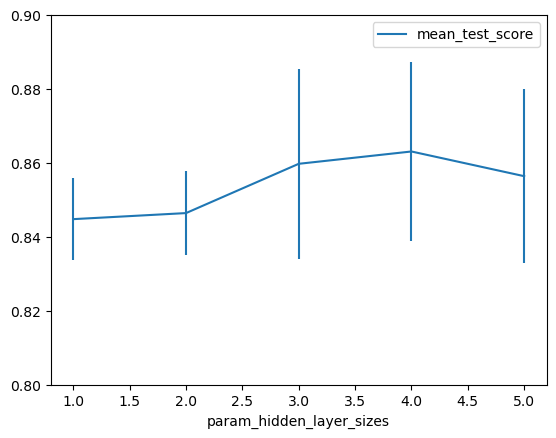

In [13]:
pd.DataFrame(gridSearch.cv_results_)[display].plot(x='param_hidden_layer_sizes', 
                                                   y='mean_test_score', yerr='std_test_score', ylim=(0.8, 0.9))